# Objective and brief description of the problem

The objective of this project is to develop a CycleGAN model capable of performing unpaired image-to-image translation, specifically transforming photographs into Monet-style paintings. This project seeks to capture and replicate the unique artistic characteristics of Monet’s style—such as color palette, brushstroke patterns, and tonal variations—while preserving the core content and structure of the original photographs. The model should be able to generate visually authentic Monet-like images from real-world photos and also reverse this transformation by converting Monet paintings into photo-realistic images.

The problem this project addresses is how to achieve realistic and high-quality artistic style transfer from photographs to Monet-inspired paintings without needing paired image datasets. Traditional style transfer methods require pairs of images (e.g., a photo and its Monet-styled version), which are often unavailable, making unpaired style transfer a challenging task. This project uses a CycleGAN model to overcome this limitation by learning the Monet painting style and applying it to photographs, enabling the transformation of images across different styles in the absence of paired training data.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [5]:
#GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH = 'C:/Users/alsin/python/UOCB/Deeplearning/week5/gan-getting-started'


In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [8]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

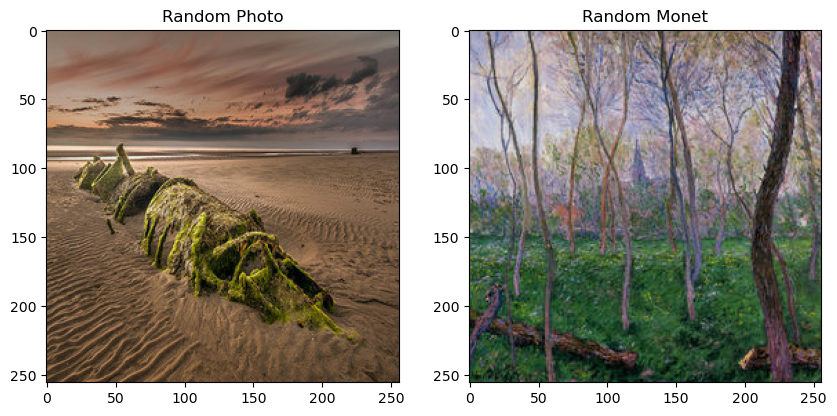

In [66]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# Load a random image from the datasets
def get_random_image(dataset):
    # Shuffle the dataset to pick a random image
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    # Take one sample
    random_image = next(iter(shuffled_dataset))
    return random_image

# Get a random Monet image and a random photo
random_monet_image = get_random_image(monet_ds)
random_photo_image = get_random_image(photo_ds)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Plot the random images
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Random Photo')
plt.imshow(random_photo_image[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random Monet')
plt.imshow(random_monet_image[0] * 0.5 + 0.5)

plt.show()

# EDA
By analyzing pixel intensity histograms, we observe how Monet paintings may use a different range of color intensities or emphasize certain colors (e.g., blues, greens) more heavily, unlike typical photos. Color histograms reveal differences in channel distribution, allowing the model to prioritize or adjust specific color tones to achieve a more accurate Monet-style effect. Additionally, calculating the average color of each dataset helps in understanding the general color palette used in Monet paintings, enabling adjustments in the model to match this palette.

Monet Image Shape: (256, 256, 3)
Min Pixel Value: -1.0
Max Pixel Value: 1.0


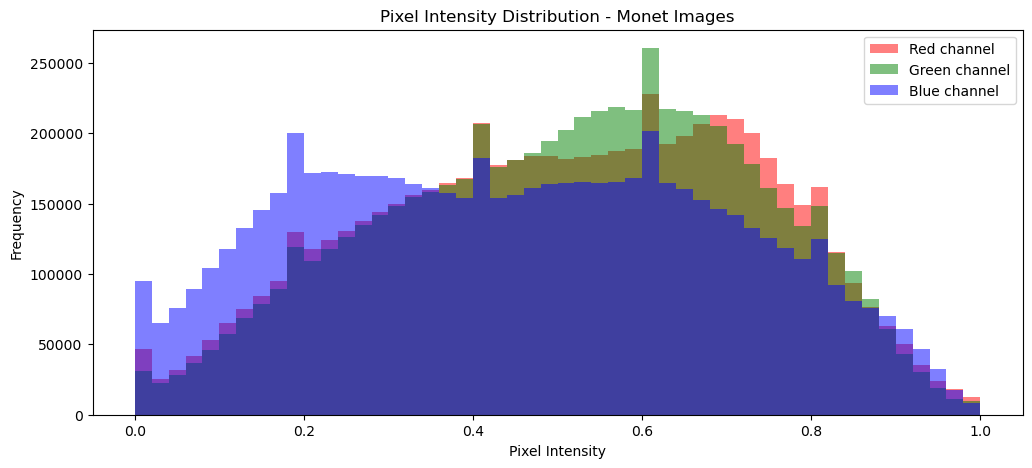

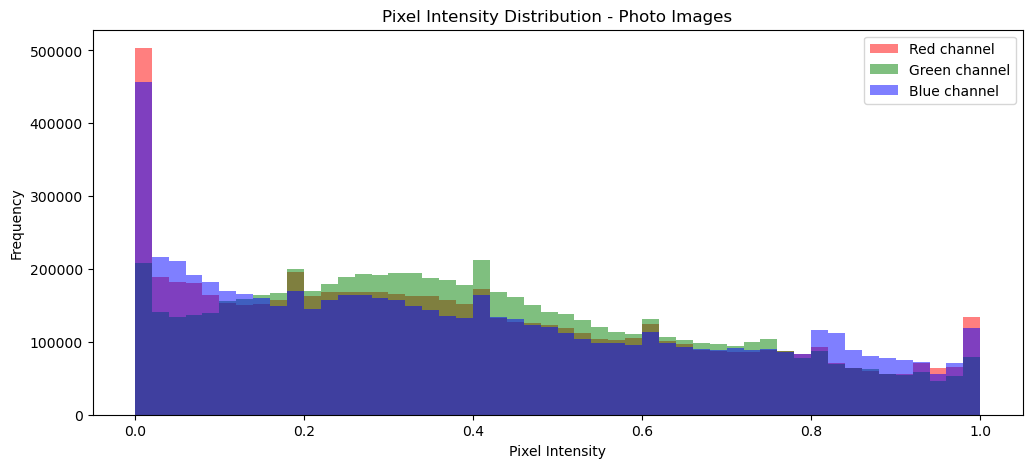

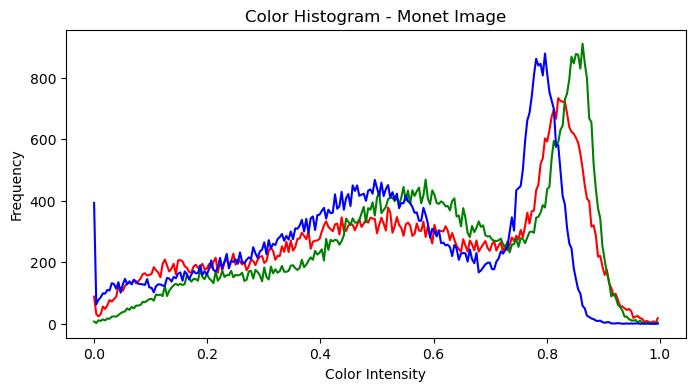

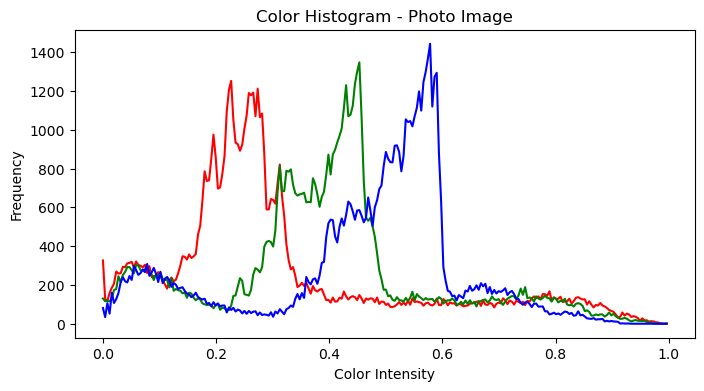

Average Color of Monet Images: [0.51343068 0.5160425  0.45625965]
Average Color of Photo Images: [0.39228855 0.4108779  0.39969615]


In [123]:
import numpy as np

for image in monet_ds.take(1):
    print("Monet Image Shape:", image[0].shape)
    print("Min Pixel Value:", tf.reduce_min(image[0]).numpy())
    print("Max Pixel Value:", tf.reduce_max(image[0]).numpy())

def plot_pixel_intensity_distribution(dataset, title):
    red_vals, green_vals, blue_vals = [], [], []

    for image in dataset.take(100):  # Sample 100 images
        img = (image[0].numpy() * 0.5 + 0.5).astype(np.float32)  # Scale to [0, 1]
        red_vals.extend(img[:, :, 0].flatten())
        green_vals.extend(img[:, :, 1].flatten())
        blue_vals.extend(img[:, :, 2].flatten())

    plt.figure(figsize=(12, 5))
    plt.hist(red_vals, bins=50, alpha=0.5, color='red', label='Red channel')
    plt.hist(green_vals, bins=50, alpha=0.5, color='green', label='Green channel')
    plt.hist(blue_vals, bins=50, alpha=0.5, color='blue', label='Blue channel')
    plt.title(f'Pixel Intensity Distribution - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot for both datasets
plot_pixel_intensity_distribution(monet_ds, "Monet Images")
plot_pixel_intensity_distribution(photo_ds, "Photo Images")

def plot_color_histogram(image, title):
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(8, 4))
    for i, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            image[:, :, i], bins=256, range=(0, 1)
        )
        plt.plot(bin_edges[0:-1], histogram, color=color)
    plt.title(f'Color Histogram - {title}')
    plt.xlabel('Color Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Display a sample color histogram for one Monet and one photo image
sample_monet_image = next(iter(monet_ds.take(1)))[0].numpy() * 0.5 + 0.5
sample_photo_image = next(iter(photo_ds.take(1)))[0].numpy() * 0.5 + 0.5

plot_color_histogram(sample_monet_image, "Monet Image")
plot_color_histogram(sample_photo_image, "Photo Image")

def calculate_average_color(dataset, num_samples=100):
    avg_color = np.zeros(3)
    for image in dataset.take(num_samples):
        img = (image[0].numpy() * 0.5 + 0.5)
        avg_color += img.mean(axis=(0, 1))
    avg_color /= num_samples
    return avg_color

monet_avg_color = calculate_average_color(monet_ds)
photo_avg_color = calculate_average_color(photo_ds)

print("Average Color of Monet Images:", monet_avg_color)
print("Average Color of Photo Images:", photo_avg_color)

# Build the generator

This code defines a generator model for a CycleGAN, which converts images from one domain to another through a series of downsampling and upsampling layers. The downsample and upsample functions construct the model’s core architecture, enabling it to learn both low-level features and complex image structures. The benefits of using sequential downsampling and upsampling blocks are twofold: downsampling layers help the model capture essential details by reducing spatial dimensions, while upsampling layers allow it to reconstruct high-quality images in the target style.

The code also employs LayerNormalization in place of InstanceNormalization, which eliminates the dependency on external libraries while maintaining normalization across the channels. Additionally, skip connections between corresponding downsample and upsample layers help retain important details, ensuring that the reconstructed image closely resembles the input content. This setup improves training stability, reduces artifacts in generated images, and enables the model to produce stylistically consistent, visually pleasing outputs.

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, Sequential

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        # Replace InstanceNormalization with LayerNormalization
        result.add(layers.LayerNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # Replace InstanceNormalization with LayerNormalization
    result.add(layers.LayerNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

This code defines the discriminator model for a CycleGAN, which classifies images as real or generated within each domain (e.g., distinguishing real Monet paintings from generated ones). The Discriminator model uses sequential downsampling layers to progressively reduce the spatial dimensions, allowing it to capture essential features at multiple scales. The architecture includes LayerNormalization to stabilize training without the need for external libraries, improving generalization by normalizing activations. Additionally, the use of LeakyReLU activation allows the model to better handle sparse gradients, which is beneficial for discriminating between real and generated images.

The code further initializes two generators and two discriminators for the CycleGAN architecture: one pair for transforming photos to Monet-style paintings and vice versa, and another pair to evaluate the authenticity of these transformations. This setup enables the CycleGAN to learn the style transformation in both directions (photo to Monet and Monet to photo) while refining the quality of the generated images through adversarial feedback. Overall, this architecture enhances the realism and quality of style-transferred images by leveraging the unique benefits of discriminative and generative components.

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, initializers

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)    # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)    # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    # Use LayerNormalization instead of InstanceNormalization
    norm1 = layers.LayerNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [57]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

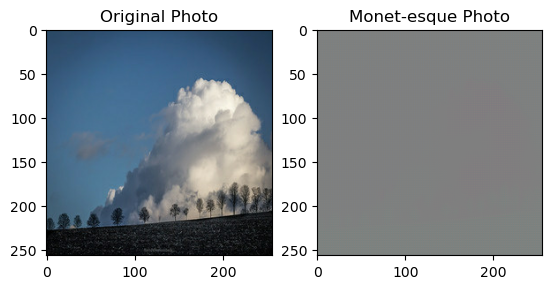

In [72]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

# Build the CycleGAN model

This CycleGan class encapsulates the complete CycleGAN architecture, integrating generators, discriminators, and loss functions into a cohesive model with structured training dynamics. The class provides several benefits: First, it defines and manages the CycleGAN's multiple components (two generators and two discriminators), making the architecture modular and reusable. By including lambda_cycle as a parameter, the class allows control over cycle consistency strength, enabling fine-tuning of content retention during style transformations.

The train_step method is where the main CycleGAN training process occurs, handling complex tasks like calculating cycle consistency loss, identity loss, and adversarial losses for both domains (Monet to photo and vice versa). Through a single train_step, this design ensures each generator learns not only to convert images but also to reconstruct them back to their original form, preserving content integrity across transformations. Furthermore, persistent gradient tapes capture gradients for both generators and discriminators, supporting efficient backpropagation and stable optimization. Overall, this structured class makes it easier to customize, extend, and debug CycleGAN's behavior, facilitating the development of high-quality style transfer models.

In [75]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

This code defines essential loss functions for training a CycleGAN model under a distributed strategy scope, which ensures compatibility with multi-GPU or TPU setups for faster training. The discriminator_loss function calculates loss for the discriminators by using binary cross-entropy to measure their ability to differentiate real images from generated ones. This balanced loss for real and generated images improves the discriminator’s stability during adversarial training.

The generator_loss function calculates adversarial loss for the generators, encouraging them to produce realistic images that can fool the discriminator. The calc_cycle_loss function is key to CycleGAN’s design; it enforces cycle consistency by penalizing the difference between an original image and its cycled version, scaled by the parameter LAMBDA. This constraint helps retain content structure during style transfer. Lastly, identity_loss encourages the model to produce images close to the original when already in the target domain, which helps maintain realistic colors and details. Together, these loss functions balance adversarial training with content preservation, ensuring the CycleGAN produces high-quality, stylized images while minimizing distortions.

In [78]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [81]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [84]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [87]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

The Adam optimizers are configured with a learning rate of 2 e-4 an beta 1 of 0.5. which are standard for GANs to stabilize training and control gradient updates, preventing oscillations. Each generator and discriminator has its own optimizer, allowing for independent updates that improve the model’s adversarial balance and enhance convergence.

The CycleGan model is compiled with the relevant loss functions: generator loss, discriminator loss, cycle consistency loss, and identity loss, which collectively guide the model in producing realistic and stylistically accurate transformations. Finally, the fit method initiates training on the paired datasets (monet_ds and photo_ds) for 5 epochs, enabling the model to learn transformations from photos to Monet paintings and vice versa. This setup ensures that the CycleGAN is optimized for both artistic fidelity and content preservation, facilitating a robust style transfer process.


In [90]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [92]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [96]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - monet_disc_loss: 0.5704 - monet_gen_loss: 3.7597 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.6937
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - monet_disc_loss: 0.5540 - monet_gen_loss: 3.6442 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.5521
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.3071 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.3506
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - monet_disc_loss: 0.5898 - monet_gen_loss: 3.1369 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.2240
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - monet_disc_loss: 0.6348 - monet_gen_loss: 3.0281 - photo_disc_loss: 0.5674 - photo_gen_loss: 3.2740


# Visualize Monet-esque photos
The visualization provides a direct comparison between randomly selected input photos and their "Monet-esque" transformations produced by the CycleGAN model's generator. By shuffling the dataset, a random sample of photos is selected for display, ensuring diverse representations across different image styles and compositions. The original photos and their corresponding generated images are displayed side by side, with the generator's output scaled to standard color intensities for accurate visual comparison. This layout allows us to observe how effectively the model has captured Monet's artistic style, including brushstroke patterns, color palettes, and tonal shifts, while preserving the content structure of the original photos. The side-by-side comparison offers valuable insights into the model's performance, highlighting the quality and fidelity of its style transfer capabilities.

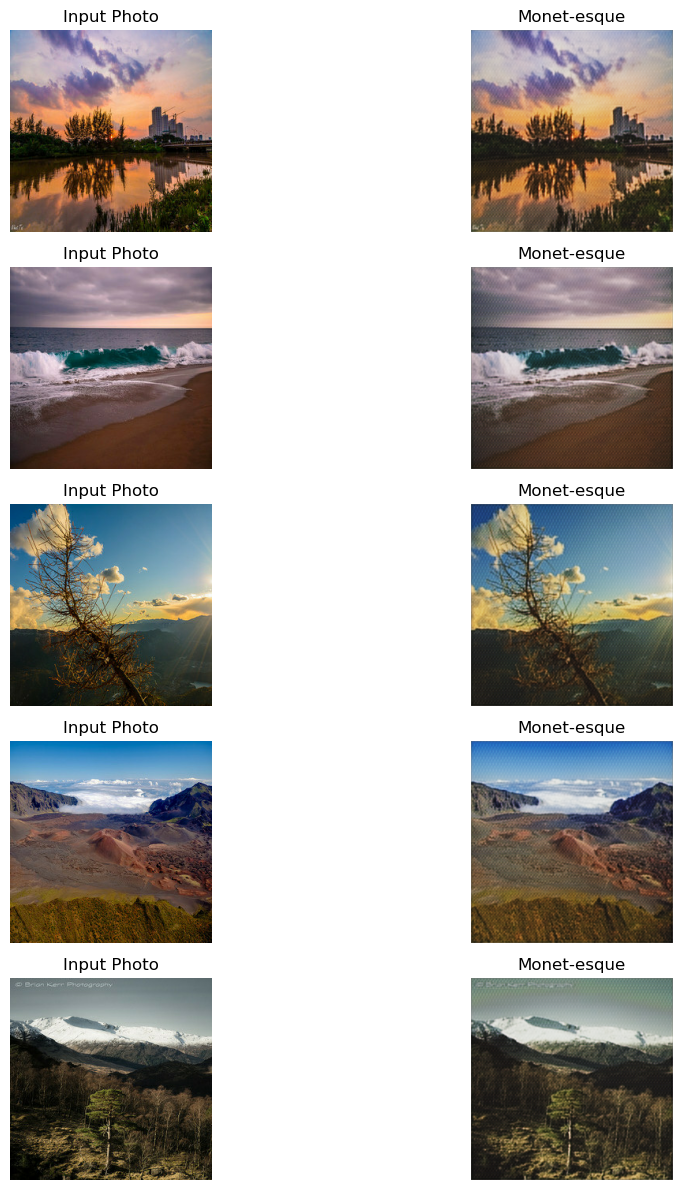

In [108]:
# Shuffle the dataset for randomness
photo_ds_shuffled = photo_ds.shuffle(1000)

# Visualize random images with their Monet-esque transformations
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds_shuffled.take(5)):
    # Generate Monet-esque image
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 0.5 + 0.5) * 255.0  # Scale to [0, 255]
    prediction = prediction.astype(np.uint8)
    
    # Scale original image to [0, 255] for display
    img = (img[0] * 0.5 + 0.5) * 255.0
    img = img.numpy().astype(np.uint8)

    # Display original and generated images
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Conclusion

This CycleGAN implementation successfully transforms photos into Monet-style paintings and vice versa, leveraging a robust adversarial architecture and essential loss functions to balance artistic transformation with content fidelity. The model utilizes paired generators and discriminators for each domain, ensuring bidirectional style transfer. Through cycle consistency and identity losses, it preserves key details and color consistency, allowing for high-quality transformations that capture the Monet style's distinctive aesthetics.

This project constructed a CycleGAN model to perform unpaired image-to-image translation, focusing on converting photos to Monet-inspired artworks. Key components included carefully tuned loss functions, such as adversarial, cycle consistency, and identity loss, as well as independent optimizers for each generator and discriminator. By training under a distributed strategy scope, the model efficiently learned to generate visually compelling images that accurately reflect Monet's style while retaining the essence of the original photo content. This approach demonstrates the effectiveness of CycleGAN for complex style transfer tasks, providing a flexible framework for further exploration in creative AI applications.

# Create submission file

In [140]:
# import PIL
# ! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")